# Perform sentimental analysis on the Elon-musk tweets (Elon-musk.csv)

In [1]:
!pip uninstall nltk

^C


In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import string # special operations on strings
import spacy # language models
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline


from tqdm.notebook import tqdm_notebook

from wordcloud import WordCloud
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize,sent_tokenize,TweetTokenizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem import WordNetLemmatizer

import snscrape.modules.twitter as sntwitter

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer


# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('conll2000')
stop = set(stopwords.words("english"))

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-dat

In [4]:
data= pd.read_csv('Elon_musk.csv',encoding ='Latin-1',error_bad_lines=False)
data.rename({'Text':'Tweets'},axis=1,inplace=True)
data.head()


,Unnamed: 0,Tweets
0,1,@kunalb11 Im an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...


In [5]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


# Data Exploration
### Number of words 

In [6]:
data['Word_count']=data['Tweets'].apply (lambda x:len(str(x).split(' ')))
data.head()

,Tweets,Word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


### Number of Characters


In [7]:
data['Char_count']=data['Tweets'].str.len()
data.head()

,Tweets,Word_count,Char_count
0,@kunalb11 Im an alien,4,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13,82
2,@joerogan @Spotify Great interview!,4,35
3,@gtera27 Doge is underestimated,4,31
4,@teslacn Congratulations Tesla China for amazi...,17,104


### Number of stopwords

In [8]:
data['Stopwords']=data['Tweets'].apply(lambda x:len([x for x in x.split() if x in stop]))
data.head()

,Tweets,Word_count,Char_count,Stopwords
0,@kunalb11 Im an alien,4,22,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13,82,4
2,@joerogan @Spotify Great interview!,4,35,0
3,@gtera27 Doge is underestimated,4,31,1
4,@teslacn Congratulations Tesla China for amazi...,17,104,5


### Number of Numerics

In [9]:
data['numerics'] = data['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


### Number of Special characters 

In [10]:
data['Spcl_char']= data['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
data[['Tweets','Spcl_char']].head()

,Tweets,Spcl_char
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


### Number of Uppercase words


In [11]:
data['upper'] = data['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['Tweets','upper']].head()

,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


### Number of Rare Words


In [12]:
rare = pd.Series(' '.join(data['Tweets']).split()).value_counts()[-10:]
rare

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

### Number of user tags in tweets (@)


In [13]:
data['Tweets'].str.contains('@').value_counts()

True     1678
False     321
Name: Tweets, dtype: int64

In [14]:
data['Tweets'].str.contains('@').value_counts()/len(data)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

### Number of links attached in tweets

In [15]:
data['Tweets'].str.contains('https://').value_counts()

False    1356
True      643
Name: Tweets, dtype: int64

In [16]:
data['Tweets'].str.contains('https://').value_counts()/len(data)

False    0.678339
True     0.321661
Name: Tweets, dtype: float64

In [17]:
data.columns

Index(['Tweets', 'Word_count', 'Char_count', 'Stopwords', 'numerics',
       'Spcl_char', 'upper'],
      dtype='object')

In [18]:
# Drop the new columns
data.drop(['Word_count', 'Char_count', 'Stopwords', 'Spcl_char',
       'numerics', 'upper'],axis=1,inplace=True)
data.head()

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


### N-grams
- N-grams are the combination of multiple words used together. 
- Ngrams with N=1 are called unigrams.
- Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

Unigrams do not usually contain as much information as compared to bigrams and trigrams. The basic principle behind n-grams is that they capture the language structure, like what letter or word is likely to follow the given one.

In [19]:
TextBlob(data['Tweets'][1]).ngrams(1)

[WordList(['ID_AA_Carmack']),
 WordList(['Ray']),
 WordList(['tracing']),
 WordList(['on']),
 WordList(['Cyberpunk']),
 WordList(['with']),
 WordList(['HDR']),
 WordList(['is']),
 WordList(['next-level']),
 WordList(['Have']),
 WordList(['you']),
 WordList(['tried']),
 WordList(['it'])]

In [20]:
TextBlob(data['Tweets'][2]).ngrams(1)

[WordList(['joerogan']),
 WordList(['Spotify']),
 WordList(['Great']),
 WordList(['interview'])]

In [21]:
TextBlob(data['Tweets'][3]).ngrams(1)

[WordList(['gtera27']),
 WordList(['Doge']),
 WordList(['is']),
 WordList(['underestimated'])]

In [22]:
TextBlob(data['Tweets'][4]).ngrams(1)

[WordList(['teslacn']),
 WordList(['Congratulations']),
 WordList(['Tesla']),
 WordList(['China']),
 WordList(['for']),
 WordList(['amazing']),
 WordList(['execution']),
 WordList(['last']),
 WordList(['year']),
 WordList(['Now']),
 WordList(['on']),
 WordList(['to']),
 WordList(['the']),
 WordList(['next']),
 WordList(['for']),
 WordList(['even']),
 WordList(['more'])]

In [23]:
TextBlob(data['Tweets'][4]).ngrams(2)

[WordList(['teslacn', 'Congratulations']),
 WordList(['Congratulations', 'Tesla']),
 WordList(['Tesla', 'China']),
 WordList(['China', 'for']),
 WordList(['for', 'amazing']),
 WordList(['amazing', 'execution']),
 WordList(['execution', 'last']),
 WordList(['last', 'year']),
 WordList(['year', 'Now']),
 WordList(['Now', 'on']),
 WordList(['on', 'to']),
 WordList(['to', 'the']),
 WordList(['the', 'next']),
 WordList(['next', 'for']),
 WordList(['for', 'even']),
 WordList(['even', 'more'])]

In [24]:
TextBlob(data['Tweets'][4]).ngrams(3)

[WordList(['teslacn', 'Congratulations', 'Tesla']),
 WordList(['Congratulations', 'Tesla', 'China']),
 WordList(['Tesla', 'China', 'for']),
 WordList(['China', 'for', 'amazing']),
 WordList(['for', 'amazing', 'execution']),
 WordList(['amazing', 'execution', 'last']),
 WordList(['execution', 'last', 'year']),
 WordList(['last', 'year', 'Now']),
 WordList(['year', 'Now', 'on']),
 WordList(['Now', 'on', 'to']),
 WordList(['on', 'to', 'the']),
 WordList(['to', 'the', 'next']),
 WordList(['the', 'next', 'for']),
 WordList(['next', 'for', 'even']),
 WordList(['for', 'even', 'more'])]

# Data Visualisation

In [25]:
import itertools
a=list(itertools.chain
      (*data.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist()))

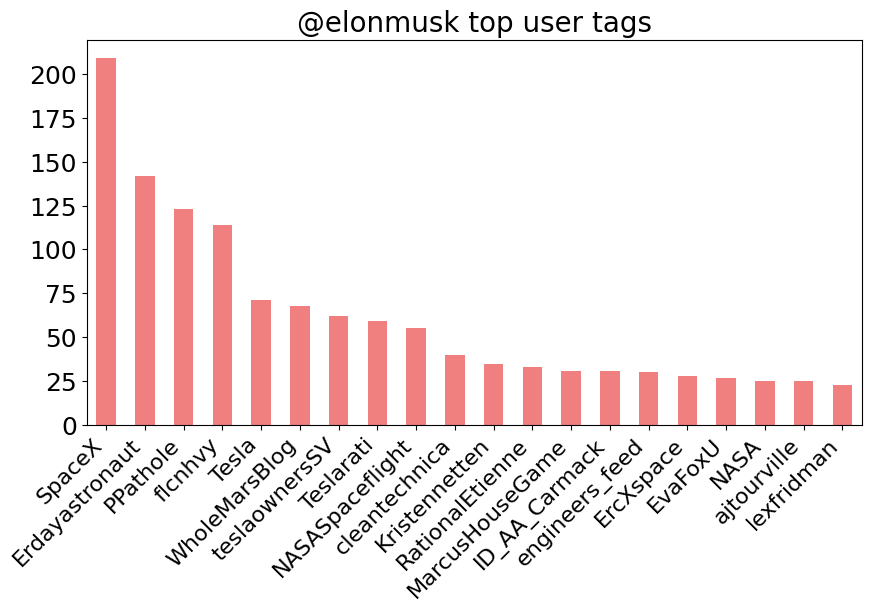

In [26]:
pd.Series(a).value_counts().head(20).plot.bar(figsize=(10,5), fontsize=18,color='lightcoral')
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

# Text Pre-Processing


## Cleaning the tweets

### Collecting all the Tweets for Textual Pre-Processing


In [27]:
tweets=[Text.strip() for Text in data.Tweets] # remove both the leading and the trailing characters
tweets=[Text for Text in tweets if Text] # removes empty strings, because they are considered in Python as False
tweets[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

In [28]:
#Combining all the Tweets into Text
# Joining the list into one string/text
tweets_join=' '.join(tweets)
tweets_join[:500]

'@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it? @joerogan @Spotify Great interview! @gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!! Happy New Year of the Ox! https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed! '

### Using TweetTokenizer to remove all the Twitter Username Handles


In [29]:
tknzr = TweetTokenizer(strip_handles=True)
tweets_tokens=tknzr.tokenize(tweets_join)
print(tweets_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'next-level', '.', 'Have', 'you', 'tried', 'it', '?', 'Great', 'interview', '!', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', '.', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', '!', '!', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', '!', 'https://t.co/9WFKMYu2oj', 'Frodo', 'was', 'the', 'underdoge', ',', 'All', 'thought', 'he', 'would', 'fail', ',', 'Himself', 'most', 'of', 'all', '.', 'https://t.co/zGxJFDzzrM', 'Haha', 'thanks', ':)', 'Indeed', '!', 'Tweets', 'definitely', 'do', 'not', 'represent', 'real-world', 'time', 'allocation', '.', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with']


In [30]:
#Joining all the Tokenized words into Text/String
# Again Joining the list into one string/text

tweet_tokens=' '.join(tweets_tokens)
tweet_tokens[:500]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox ! https://t.co/9WFKMYu2oj Frodo was the underdoge , All thought he would fail , Himself most of all . https://t.co/zGxJFDzzrM Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the'

In [31]:
# remove https or url within text
no_url_text=re.sub(r'http\S+', '', tweet_tokens)
no_url_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox !  Frodo was the underdoge , All thought he would fail , Himself most of all .  Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  It \x92 s getting real Bought some Dogecoin for lil X , so he can be a toddler hodler He definitely has issues , but the sentencing seems a bit high Thanks for fixing Please unlock my account <U+0001F923> <U+0001F923> This is true power haha  Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT : NASA has selected Falcon Heavy to launch the first two elements of the lunar Gateway together on one mission !  Yes Once we ca

In [32]:
# Remove Punctuations 
no_punc_text=no_url_text.translate(str.maketrans('','',string.punctuation))
no_punc_text[:500]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox   Frodo was the underdoge  All thought he would fail  Himself most of all   Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  I'

In [33]:
text_tokens=word_tokenize(no_punc_text)
print(text_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'nextlevel', 'Have', 'you', 'tried', 'it', 'Great', 'interview', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', 'Frodo', 'was', 'the', 'underdoge', 'All', 'thought', 'he', 'would', 'fail', 'Himself', 'most', 'of', 'all', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'do', 'not', 'represent', 'realworld', 'time', 'allocation', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', 'so', 'he', 'can', 'be']


In [34]:
len(text_tokens)

17847

In [35]:
# Remove stopwords and make lower

stop_words=stopwords.words('english')
sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
stop_words.extend(sw_list)

no_stop_tokens=[word for word in text_tokens if not word in stop_words]
print(no_stop_tokens[:100])


['alien', 'Ray', 'tracing', 'Cyberpunk', 'HDR', 'nextlevel', 'Have', 'tried', 'Great', 'interview', 'Doge', 'underestimated', 'Congratulations', 'Tesla', 'China', 'amazing', 'execution', 'last', 'year', 'Now', 'next', 'even', 'Happy', 'New', 'Year', 'Ox', 'Frodo', 'underdoge', 'All', 'thought', 'would', 'fail', 'Himself', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'The', 'entertaining', 'outcome', 'likely', 'Just', 'sent', 'Just', 'agree', 'Clubhouse', 'It', 'getting', 'real', 'Bought', 'Dogecoin', 'lil', 'X', 'toddler', 'hodler', 'He', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'Thanks', 'fixing', 'Please', 'unlock', 'account', 'This', 'true', 'power', 'Any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'Your', 'app', 'sucks', 'RT', 'NASA', 'selected', 'Falcon', 'Heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'Gateway', 'together', 'one', 'mission']


In [36]:
 # Making the all Text in Lowercase
lw=[Text.lower() for Text in no_stop_tokens]
print(lw[:100])

['alien', 'ray', 'tracing', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tried', 'great', 'interview', 'doge', 'underestimated', 'congratulations', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thanks', 'indeed', 'tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'sent', 'just', 'agree', 'clubhouse', 'it', 'getting', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'thanks', 'fixing', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'your', 'app', 'sucks', 'rt', 'nasa', 'selected', 'falcon', 'heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'gateway', 'together', 'one', 'mission']


### Stemming the Text using NLTK Library


In [37]:
# Stemming 
ps=PorterStemmer()
stem_tokens=[ps.stem(word) for word in lw]
print(stem_tokens[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tri', 'great', 'interview', 'doge', 'underestim', 'congratul', 'tesla', 'china', 'amaz', 'execut', 'last', 'year', 'now', 'next', 'even', 'happi', 'new', 'year', 'ox', 'frodo', 'underdog', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'inde', 'tweet', 'definit', 'repres', 'realworld', 'time', 'alloc', 'the', 'entertain', 'outcom', 'like', 'just', 'sent', 'just', 'agre', 'clubhous', 'it', 'get', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definit', 'issu', 'sentenc', 'seem', 'bit', 'high', 'thank', 'fix', 'pleas', 'unlock', 'account', 'thi', 'true', 'power', 'ani', 'crypto', 'wallet', 'give', 'privat', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavi', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'togeth', 'one', 'mission']


### Lemmatization of Text data using Spacy library


In [38]:
# Lemmatization
nlp=spacy.load('en_core_web_sm')
doc=nlp(' '.join(lw))
print(doc[:100])

alien ray tracing cyberpunk hdr nextlevel have tried great interview doge underestimated congratulations tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thanks indeed tweets definitely represent realworld time allocation the entertaining outcome likely just sent just agree clubhouse it getting real bought dogecoin lil x toddler hodler he definitely issues sentencing seems bit high thanks fixing please unlock account this true power any crypto wallet give private keys avoided costs your app sucks rt nasa selected falcon heavy launch first two elements lunar gateway together one mission


In [39]:
lemmas=[token.lemma_ for token in doc]
print(lemmas[:50])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'try', 'great', 'interview', 'doge', 'underestimate', 'congratulation', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'think', 'would', 'fail', 'himself', 'haha', 'thank', 'indeed', 'tweet', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'send', 'just', 'agree']


In [40]:
clean_tweet=' '.join(lemmas)
clean_tweet[:500]

'alien ray trace cyberpunk hdr nextlevel have try great interview doge underestimate congratulation tesla china amazing execution last year now next even happy new year ox frodo underdoge all think would fail himself haha thank indeed tweet definitely represent realworld time allocation the entertaining outcome likely just send just agree clubhouse it get real buy dogecoin lil x toddler hodler he definitely issue sentencing seem bit high thank fix please unlock account this true power any crypto '

# Generate word cloud

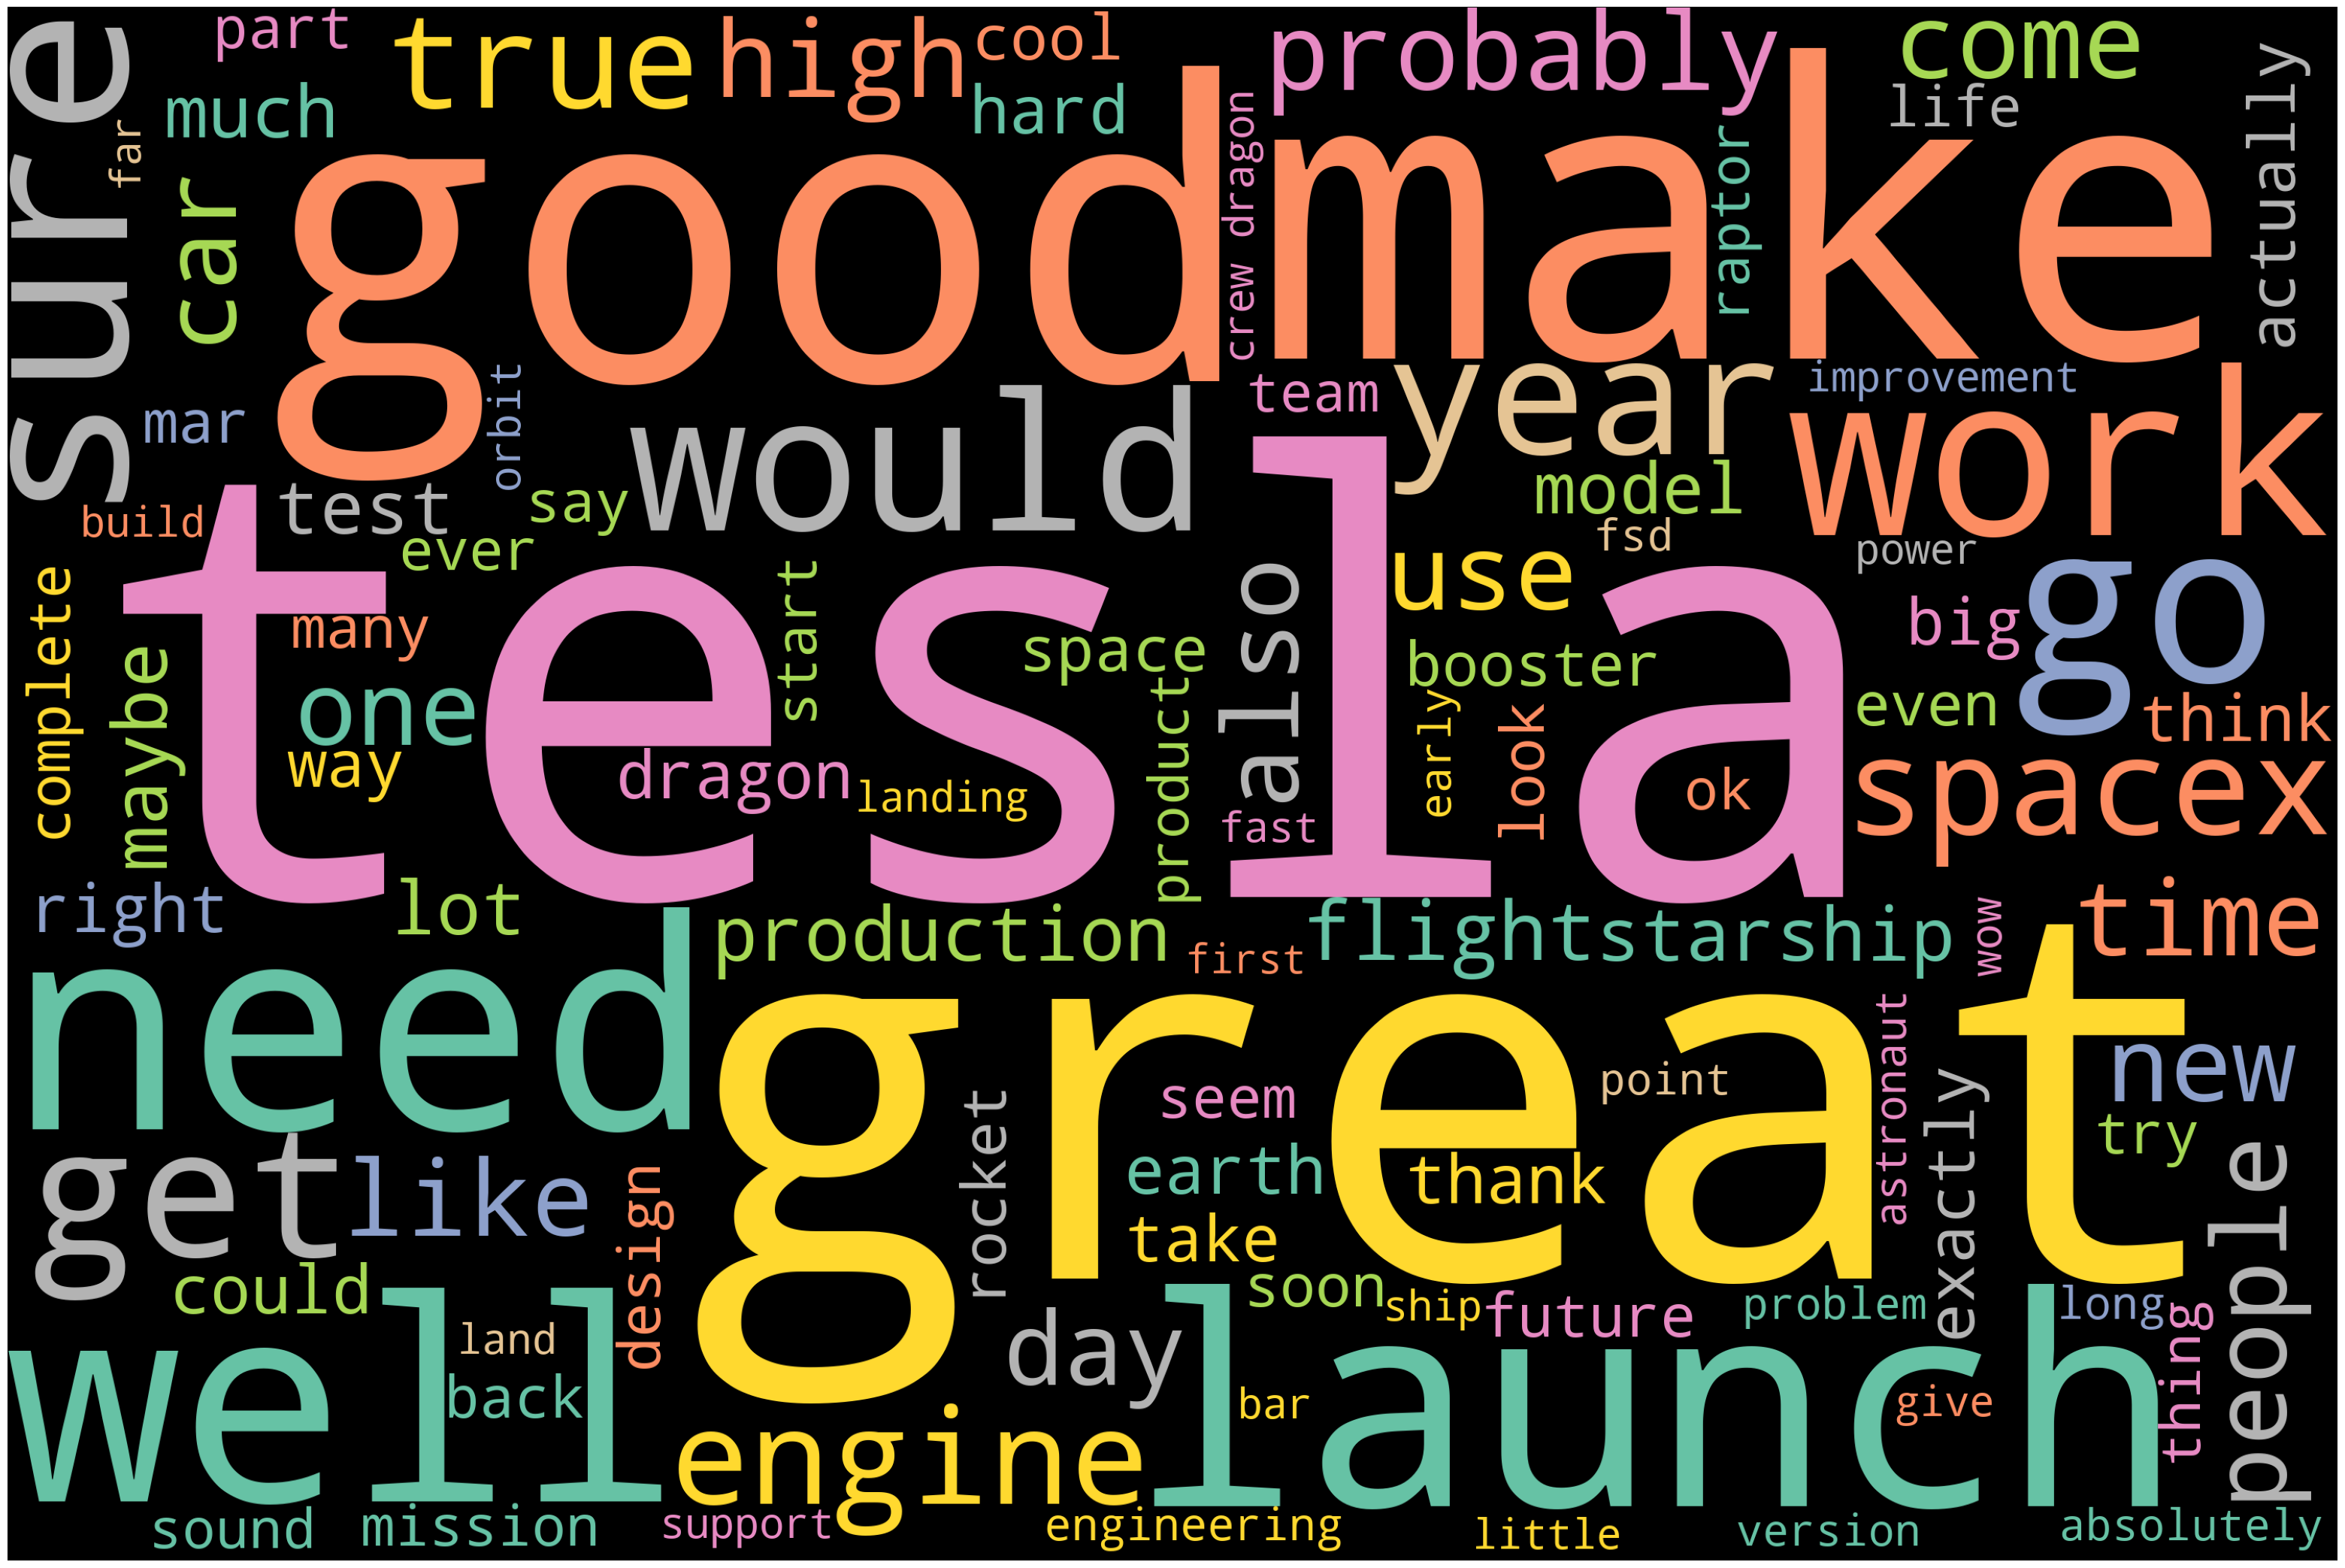

In [41]:
# make function for plotting wordcloud

def plot_wc(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')
    
wc=WordCloud(width=3000,height=2000,background_color='black',
             max_words=100,colormap='Set2',stopwords=stop_words).generate(clean_tweet)
plot_wc(wc)

From the above woedcloud we can see that the frequency of the word: 

- tesla,great,launch,good,well,spacex...... are used most of time

# Text Pre-processing Techniques
## For Sentiment Analysis
**Keeping the DataFrame intact and each tweets separate from each other for sentiment analysis.**

In [42]:
import string

def clean_text(text):
    '''Make text lowercase, remove @ ,remove text in square brackets, remove punctuation and remove words containing numbers,https,#.'''
    text = text.lower()
    text=re.sub('@[A-Za-z0-9]+','',text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+"," ",text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('@[\w]*','',text) 
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text

clean = lambda x: clean_text(x)
data['clean_text']=data['Tweets'].apply(clean_text)
data.head(10)


,Tweets,clean_text
0,@kunalb11 Im an alien,im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,aacarmack ray tracing on cyberpunk with hdr is...
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent re...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely


In [ ]:
# Function to remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean_text']=data['clean_text'].apply(lambda x: remove_emoji(x))
data.head(10)

### Removing stopwords

In [43]:
stop_words=stopwords.words('english')
sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
stop_words.extend(sw_list)
stopwords_set = set(stop_words)
cleaned_tweets = []

for index, row in data.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.clean_text.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
data['Absolute_clean'] = cleaned_tweets
data.head(10)


,Tweets,clean_text,Absolute_clean
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,aacarmack ray tracing on cyberpunk with hdr is...,aacarmack ray tracing cyberpunk hdr nextlevel ...
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execu...,congratulations tesla china amazing execution ...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy new year of the ox,happy new year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo was the underdoge all thought he would f...,frodo underdoge thought would fail httpstcozgx...
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha thanks,thanks
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,indeed tweets definitely do not represent re...,indeed tweets definitely represent realworld t...
9,The most entertaining outcome is the most likely,the most entertaining outcome is the most likely,entertaining outcome likely


In [52]:
#Bi-gram
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  #for tri-gram, put ngram_range=(3,3)
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(data["clean_text"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df.head()

,Bi-gram,Freq
0,will be,51
1,of the,47
2,this is,36
3,in the,36
4,to the,28


[Text(0, 0, 'will be'),
 Text(1, 0, 'of the'),
 Text(2, 0, 'this is'),
 Text(3, 0, 'in the'),
 Text(4, 0, 'to the'),
 Text(5, 0, 'to be'),
 Text(6, 0, 'we re'),
 Text(7, 0, 'is the'),
 Text(8, 0, 'should be'),
 Text(9, 0, 'on the'),
 Text(10, 0, 'it will'),
 Text(11, 0, 'would be'),
 Text(12, 0, 'lot of'),
 Text(13, 0, 'the station'),
 Text(14, 0, 'rt falcon'),
 Text(15, 0, 'for the'),
 Text(16, 0, 'we will'),
 Text(17, 0, 'is not'),
 Text(18, 0, 'need to'),
 Text(19, 0, 'if you')]

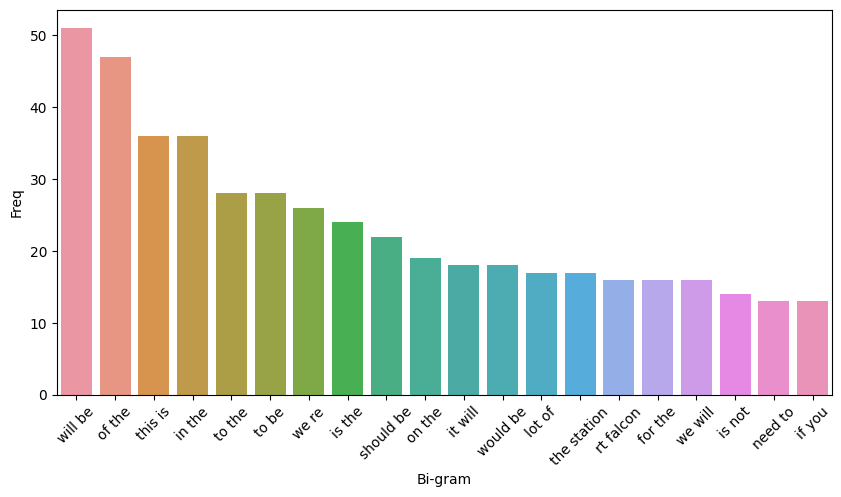

In [53]:
# Bi-gram plot
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sn.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=45,labels = top20_bigram["Bi-gram"])

In [54]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),  #for tri-gram, put ngram_range=(3,3)
            max_features=2000).fit(corpus)
    
    bag_of_words = vec1.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1],reverse=True)
    
    return words_freq[:n]

top3_words = get_top_n3_words(data["clean_text"], n=200) #top 200
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
top3_df.head()

,Tri-gram,Freq
0,falcon first stage,9
1,to the station,9
2,it will be,8
3,rt falcon first,8
4,of course still,7


[Text(0, 0, 'falcon first stage'),
 Text(1, 0, 'to the station'),
 Text(2, 0, 'it will be'),
 Text(3, 0, 'rt falcon first'),
 Text(4, 0, 'of course still'),
 Text(5, 0, 'course still love'),
 Text(6, 0, 'still love you'),
 Text(7, 0, 'one of the'),
 Text(8, 0, 'first stage has'),
 Text(9, 0, 'stage has landed'),
 Text(10, 0, 'has landed on'),
 Text(11, 0, 'that would be'),
 Text(12, 0, 'landed on the'),
 Text(13, 0, 'on the of'),
 Text(14, 0, 'the of course'),
 Text(15, 0, 'love you droneship'),
 Text(16, 0, 'first operational mission'),
 Text(17, 0, 'rt falcon launches'),
 Text(18, 0, 'need to be'),
 Text(19, 0, 'no earlier than')]

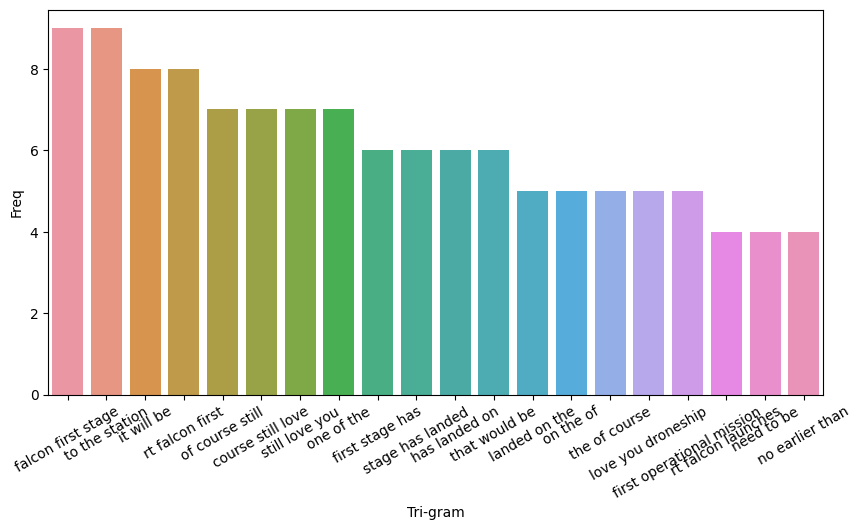

In [55]:
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sn.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=30,labels = top20_trigram["Tri-gram"])

# Basic Feature Extaction
## A. Applying bag of Words without N grams

In [44]:
cv=CountVectorizer()
tweetscv=cv.fit_transform(lemmas)
print(cv.get_feature_names()[100:200])

['74', '78', '7th', '90', '9007', '922', '948', '95', '99', 'aber', 'able', 'abo', 'aboard', 'abort', 'about', 'above', 'absence', 'absolute', 'absolutely', 'absorb', 'absorption', 'absurd', 'absurdly', 'ac', 'academia', 'accel', 'accelera', 'accelerate', 'acceleration', 'accelerator', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidental', 'accommodate', 'account', 'accura', 'accuracy', 'accurate', 'ace', 'achieve', 'achievement', 'achy', 'acquisition', 'across', 'action', 'active', 'activity', 'actual', 'actuall', 'actually', 'actuary', 'adagio', 'add', 'additive', 'address', 'administer', 'adult', 'advanc', 'advance', 'advanced', 'advantage', 'adventure', 'advertise', 'advice', 'advise', 'aero', 'afb', 'affair', 'affect', 'affordable', 'africa', 'after', 'afternoon', 'age', 'ago', 'agony', 'agree', 'ah', 'ahead', 'ahem', 'ai', 'aim', 'aiming', 'air', 'aircraft', 'airplane', 'ak', 'aka', 'alert', 'alexander', 'algo', 'algorithm', 'alien', 'aliens', 'align', 'all', '

In [45]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(tweets))):
    review = re.sub('[^a-zA-Z]', ' ', data['Absolute_clean'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1999 [00:00<?, ?it/s]

In [46]:
corpus[2]


'great interview'

In [47]:
corpus[3]

'doge underestim'

In [48]:
corpus[4]

'congratul tesla china amaz execut last year next even'

In [50]:
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()
X.shape

(1999, 5000)

In [51]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [56]:
count_df=pd.DataFrame(X,columns=cv.get_feature_names())
count_df.head()

,aacarmack,aacarmack almost,aacarmack dojo,abl,abort,absolut,absurd,acceler,accept,access,...,zimon amaz kebab,zimon definit,zimon definit need,zimon look,zimon look tasti,zimon ner,zimon ner kebab,zon,zone,zone complet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## C.TF-IDF Vectorizer

In [57]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()
X.shape

(1999, 5000)

In [58]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names())
count_df

,aacarmack,aacarmack almost,aacarmack dojo,abl,abort,absolut,absurd,acceler,accept,access,...,zimon amaz kebab,zimon definit,zimon definit need,zimon look,zimon look tasti,zimon ner,zimon ner kebab,zon,zone,zone complet
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.27526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34108,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Named Entity Recognition (NER)


In [59]:
data

,Tweets,clean_text,Absolute_clean
0,@kunalb11 Im an alien,im an alien,im alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,aacarmack ray tracing on cyberpunk with hdr is...,aacarmack ray tracing cyberpunk hdr nextlevel ...
2,@joerogan @Spotify Great interview!,great interview,great interview
3,@gtera27 Doge is underestimated,doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulations tesla china for amazing execu...,congratulations tesla china amazing execution ...
...,...,...,...
1994,"@flcnhvy True, it sounds so surreal, but the n...",true it sounds so surreal but the negative pr...,true sounds surreal negative propaganda still ...
1995,@PPathole Make sure to read ur terms &amp; con...,make sure to read ur terms amp conditions bef...,make sure read ur terms amp conditions clickin...
1996,@TeslaGong @PPathole Samwise Gamgee,samwise gamgee,samwise gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...,altho dumb and dumber is,altho dumb dumber


In [60]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=clean_tweet[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [61]:
for token in doc_block[:15]:
    print(token,token.pos_)


alien PROPN
ray NOUN
trace NOUN
cyberpunk PROPN
hdr PROPN
nextlevel NOUN
have AUX
try VERB
great ADJ
interview NOUN
doge X
underestimate PROPN
congratulation PROPN
tesla PROPN
china PROPN


In [62]:
# Filtering the nouns and verbs only
one_block=clean_tweet
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[:100])

['ray', 'trace', 'nextlevel', 'try', 'interview', 'execution', 'year', 'year', 'ox', 'frodo', 'think', 'fail', 'thank', 'tweet', 'represent', 'time', 'allocation', 'outcome', 'send', 'agree', 'clubhouse', 'get', 'buy', 'dogecoin', 'toddler', 'hodler', 'issue', 'sentencing', 'seem', 'thank', 'fix', 'unlock', 'account', 'power', 'crypto', 'wallet', 'give', 'avoid', 'cost', 'app', 'falcon', 'launch', 'gateway', 'mission', 'predict', 'cash', 'flow', 'starlink', 'ipo', 'starlink', 'endeavor', 'pass', 'chasm', 'cash', 'flow', 'year', 'cost', 'ton', 'carbon', 'sequester', 'value', 'product', 'make', 'scalable', 'g', 'mean', 'price', 'country', 'difference', 'ship', 'intend', 'earth', 'idea', 'apply', 'team', 'manage', 'carbon', 'capture', 'tesla', 'receive', 'stock', 'comp', 'stock', 'option', 'take', 'table', 'miss', 'work', 'go', 'seem', 'appear', 'fix', 'coin', 'unit', 'time', 'launch', 'tower', 'stack', 'raptor', 'orbit']


## Counting all the nouns and verbs present in the Tokens of words


In [63]:
# Counting the noun & verb tokens
X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,launch,64
1,make,64
2,year,49
3,work,48
4,go,47
5,need,42
6,come,39
7,get,38
8,day,38
9,time,37


# Detect Sentiments

In [64]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

## . Using NLTK's SentimentIntensityAnalyzer


In [65]:
sentiments_SIA = data.Absolute_clean.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_SIA.value_counts())


,Absolute_clean
pos,1801
neg,198


In [66]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(data.Absolute_clean[3])

{'neg': 0.677, 'neu': 0.323, 'pos': 0.0, 'compound': -0.2732}

In [67]:
df=pd.DataFrame()
df['Tweets'] = data.Absolute_clean
df['scores'] = data['clean_text'].apply(lambda review: sia.polarity_scores(review))
df.head()

,Tweets,scores
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,aacarmack ray tracing cyberpunk hdr nextlevel ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp..."
4,congratulations tesla china amazing execution ...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp..."


In [68]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Tweets,scores,compound
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,aacarmack ray tracing cyberpunk hdr nextlevel ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732
4,congratulations tesla china amazing execution ...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271


In [69]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Tweets,scores,compound,sentiment
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,aacarmack ray tracing cyberpunk hdr nextlevel ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative
4,congratulations tesla china amazing execution ...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive
...,...,...,...,...
1994,true sounds surreal negative propaganda still ...,"{'neg': 0.249, 'neu': 0.561, 'pos': 0.19, 'com...",-0.4215,Negative
1995,make sure read ur terms amp conditions clickin...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.5994,Positive
1996,samwise gamgee,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1997,altho dumb dumber,"{'neg': 0.659, 'neu': 0.341, 'pos': 0.0, 'comp...",-0.7003,Negative


In [70]:
df['word_count'] = df['Tweets'].apply(lambda x: len(str(x).split(" ")))
df[['Tweets','word_count']].head()

,Tweets,word_count
0,im alien,2
1,aacarmack ray tracing cyberpunk hdr nextlevel ...,7
2,great interview,2
3,doge underestimated,2
4,congratulations tesla china amazing execution ...,9


In [71]:
data.describe()

,Tweets,clean_text,Absolute_clean
count,1999,1999,1999
unique,1997,1786,1702
top,The most entertaining outcome is the most likely,,
freq,2,55,144


In [72]:
temp = df.groupby('sentiment').count()['Tweets'].reset_index().sort_values(by='Tweets',ascending=False)
temp.style.background_gradient(cmap='rainbow')

 

,sentiment,Tweets
1,Neutral,894
2,Positive,876
0,Negative,229


<AxesSubplot: xlabel='sentiment', ylabel='count'>

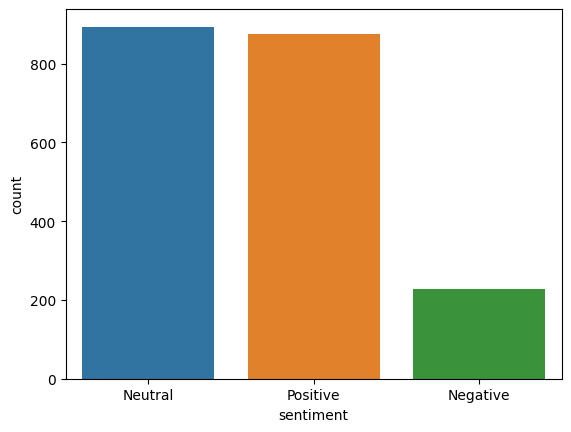

In [73]:
sn.countplot(x='sentiment',data=df)


(-1.099986221395783,
 1.0999993438759896,
 -1.0999945627269798,
 1.0999939374177345)

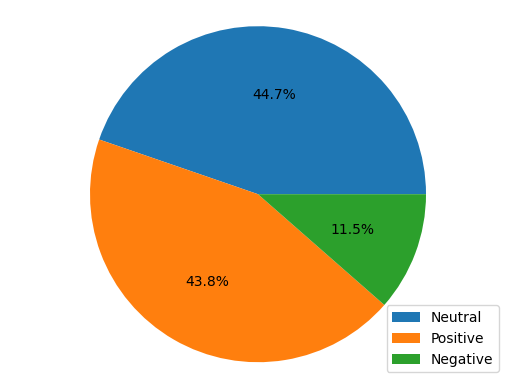

In [81]:
#Basic pie chart to view distribution of apps across various categories
#fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(aspect="equal"))
sentiments = df["sentiment"].value_counts()
labels = sentiments.index
sizes = sentiments.values
plt.pie(sizes,labeldistance=2,autopct='%1.1f%%')
plt.legend(labels=labels,loc="best")
plt.axis('equal')

<AxesSubplot: xlabel='compound', ylabel='Density'>

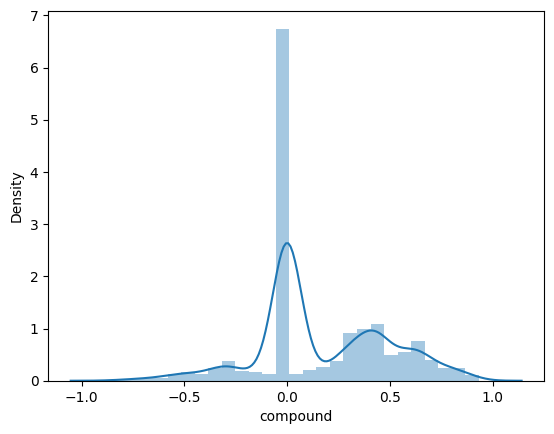

In [74]:
# Plotting the sentiment value for whole review
sn.distplot(df['compound'])

<AxesSubplot: ylabel='compound'>

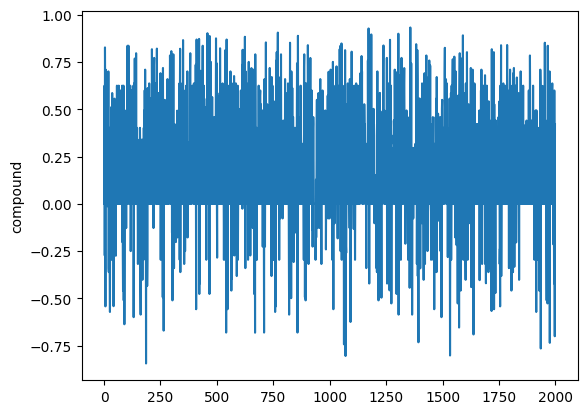

In [75]:
sn.lineplot(y='compound',x=df.index,data=df)


In [76]:
data.describe()

,Tweets,clean_text,Absolute_clean
count,1999,1999,1999
unique,1997,1786,1702
top,The most entertaining outcome is the most likely,,
freq,2,55,144


In [77]:
df

,Tweets,scores,compound,sentiment,word_count
0,im alien,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2
1,aacarmack ray tracing cyberpunk hdr nextlevel ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,7
2,great interview,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.6249,Positive,2
3,doge underestimated,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",-0.2732,Negative,2
4,congratulations tesla china amazing execution ...,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.8271,Positive,9
...,...,...,...,...,...
1994,true sounds surreal negative propaganda still ...,"{'neg': 0.249, 'neu': 0.561, 'pos': 0.19, 'com...",-0.4215,Negative,10
1995,make sure read ur terms amp conditions clickin...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.5994,Positive,9
1996,samwise gamgee,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,2
1997,altho dumb dumber,"{'neg': 0.659, 'neu': 0.341, 'pos': 0.0, 'comp...",-0.7003,Negative,3
